In [ ]:
import os
from tqdm import tqdm

data = []

base_path = '/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images'
for i in os.listdir(base_path):
    if i=='export.pkl':
        continue
    folder = base_path + '/' + i
    for j in tqdm(os.listdir(folder)):
#     img = cv2.imread(folder + '/' + j)
#     img = w2d(img, 'rbio1.1',3)
#     cv2.imwrite(new+'/'+j, img)
        data.append([folder + '/' + j,i])

import pandas as pd
df = pd.DataFrame(data, columns=['image', 'label'])
df.to_csv('train_data.csv')

In [5]:
import pandas as pd
categories = list(pd.read_csv('train_data.csv')['label'].unique())
categories

['Mild', 'Proliferate_DR', 'Moderate', 'No_DR', 'Severe']

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
from tqdm import tqdm

# Define the dataset class
# categories = pd.read_csv('train_data.csv')['label'].unique()
class DiabeticRetinopathyDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx, 1]
        image = Image.open(img_name).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label_str = self.data.iloc[idx, 2]
        label = categories.index(label_str)
        return image, torch.tensor(label)



In [7]:
# Define transformations (resizing and normalization as per ImageNet pre-training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet models expect 224x224 input
    transforms.ToTensor(),  # Convert PIL image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet stats
])

# Load your train and validation datasets
train_dataset = DiabeticRetinopathyDataset(csv_file='train_data.csv', transform=transform)
val_dataset = DiabeticRetinopathyDataset(csv_file='train_data.csv', transform=transform)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

# Load a pre-trained ResNet model
model = models.resnet50(pretrained=True)  # You can swap to resnet101 or resnet152

# Modify the fully connected layer for 5 classes (Diabetic Retinopathy stages)
num_ftrs = model.fc.in_features  # Get the number of input features to the final layer
model.fc = nn.Linear(num_ftrs, len(categories))  # Modify the classifier to output 5 classes

# Move the model to GPU (if available)
model_path = '/kaggle/working/resnet_model.pth'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load(model_path, map_location = device))
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Since it's a classification task
optimizer = optim.Adam(model.parameters(), lr=1e-4)  # Fine-tuning the entire model

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_30/3285782922.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more detai

In [14]:
# Training and validation loop
num_epochs = 20

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}, Loss: 0.0000")

    for images, labels in pbar:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights
        
        running_loss += loss.item()
        pbar.set_description(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")

    # After each epoch, print the loss
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

    # Optional: Validate on the validation set (similar to the training loop)
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():  # No gradient computation during validation
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    print(f"Validation Loss: {val_loss/len(val_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")

    # After training is complete
    torch.save(model.state_dict(), 'resnet_model.pth')

Epoch 1/20, Loss: 0.0814: 100%|██████████| 115/115 [00:33<00:00,  3.42it/s]


Epoch [1/20], Loss: 0.0814
Validation Loss: 0.0744, Accuracy: 97.38%


Epoch 2/20, Loss: 0.0680: 100%|██████████| 115/115 [00:33<00:00,  3.48it/s]


Epoch [2/20], Loss: 0.0680
Validation Loss: 0.0329, Accuracy: 98.69%


Epoch 3/20, Loss: 0.0733: 100%|██████████| 115/115 [00:33<00:00,  3.47it/s]


Epoch [3/20], Loss: 0.0733
Validation Loss: 0.0270, Accuracy: 98.83%


Epoch 4/20, Loss: 0.0556: 100%|██████████| 115/115 [00:32<00:00,  3.56it/s]


Epoch [4/20], Loss: 0.0556
Validation Loss: 0.0214, Accuracy: 98.94%


Epoch 5/20, Loss: 0.0352: 100%|██████████| 115/115 [00:32<00:00,  3.54it/s]


Epoch [5/20], Loss: 0.0352
Validation Loss: 0.0247, Accuracy: 98.80%


Epoch 6/20, Loss: 0.0364: 100%|██████████| 115/115 [00:32<00:00,  3.56it/s]


Epoch [6/20], Loss: 0.0364
Validation Loss: 0.0274, Accuracy: 98.91%


Epoch 7/20, Loss: 0.0554: 100%|██████████| 115/115 [00:32<00:00,  3.54it/s]


Epoch [7/20], Loss: 0.0554
Validation Loss: 0.0613, Accuracy: 97.68%


Epoch 8/20, Loss: 0.0473: 100%|██████████| 115/115 [00:31<00:00,  3.60it/s]


Epoch [8/20], Loss: 0.0473
Validation Loss: 0.0250, Accuracy: 98.85%


Epoch 9/20, Loss: 0.0486: 100%|██████████| 115/115 [00:32<00:00,  3.57it/s]


Epoch [9/20], Loss: 0.0486
Validation Loss: 0.0784, Accuracy: 97.24%


Epoch 10/20, Loss: 0.0612: 100%|██████████| 115/115 [00:32<00:00,  3.53it/s]


Epoch [10/20], Loss: 0.0612
Validation Loss: 0.0296, Accuracy: 98.72%


Epoch 11/20, Loss: 0.0055:  15%|█▍        | 17/115 [00:04<00:27,  3.50it/s]


KeyboardInterrupt: 

In [15]:
from sklearn.metrics import classification_report

model.eval()
all_preds = []
all_labels = []
categories = ['Mild', 'Proliferate_DR', 'Moderate', 'No_DR', 'Severe']
with torch.no_grad():
    for images, labels in val_loader:  # Assuming you have a validation or test loader
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        
        # Get the predicted class
        _, predicted = torch.max(outputs, 1)
        
        # Append the true labels and predictions to the lists
        all_labels.extend(labels.cpu().numpy())  # Convert to CPU for sklearn compatibility
        all_preds.extend(predicted.cpu().numpy())  # Convert to CPU for sklearn compatibility

# Generate the classification report
report = classification_report(all_labels, all_preds, target_names=categories)
print(report)


                precision    recall  f1-score   support

          Mild       0.99      0.98      0.98       370
Proliferate_DR       0.95      0.98      0.96       295
      Moderate       0.98      0.99      0.99       999
         No_DR       1.00      1.00      1.00      1805
        Severe       0.97      0.89      0.93       193

      accuracy                           0.99      3662
     macro avg       0.98      0.97      0.97      3662
  weighted avg       0.99      0.99      0.99      3662



In [17]:
from IPython.display import FileLink
FileLink(r'resnet_model.pth')

/kaggle/working/resnet_model.pth

In [40]:
import pywt
import numpy as np
def w2d(img, mode='haar', level=1):
    imArray = img
    
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    imArray =  np.float32(imArray)
    imArray /= 255;
    
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    coeffs_H=list(coeffs)
    coeffs_H[0] *= 0;
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    imArray_H = cv2.resize(imArray_H, (224, 224))

    return imArray_H

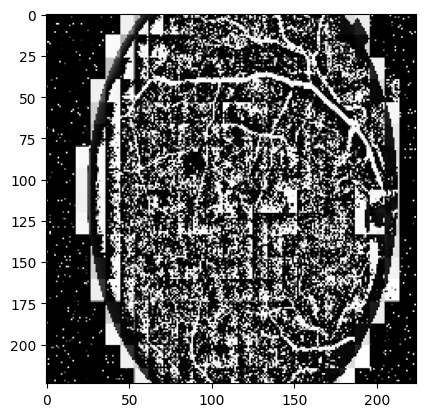

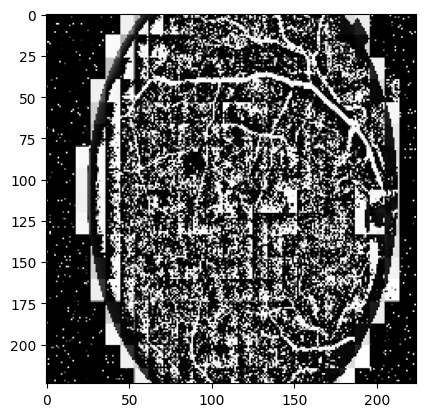

In [35]:
import cv2
import matplotlib.pyplot as plt

image = cv2.imread('/kaggle/input/aptos2019-blindness-detection/train_images/000c1434d8d7.png')
sigmaX = 10
wv1 = w2d(image, 'rbio1.1',7)
wv2 = w2d(image, 'db1',7)
gaussian = cv2.addWeighted(image, 4, cv2.GaussianBlur(image, (0,0), sigmaX), -4, 128)

gaussian = cv2.resize(gaussian, (224, 224))
wv1 = cv2.resize(wv1, (224, 224))
wv2 = cv2.resize(wv2, (224, 224))

# plt.imshow(image)
# plt.show()
plt.imshow(wv1, cmap = 'gray')
plt.show()
plt.imshow(wv2, cmap = 'gray')
plt.show()
# plt.imshow(gaussian, cmap = 'gray')
# plt.show()

In [41]:
import os
import cv2
import pandas as pd
import tqdm 

# Read the CSV file
csv_path = 'train_data.csv'
df = pd.read_csv(csv_path)

# Create a new folder for processed images
new_folder = 'processed_images'
os.makedirs(new_folder, exist_ok=True)

# Process each image and update the CSV
for index, row in tqdm.tqdm(df.iterrows()):
    old_image_path = row['image']
    new_image_path = os.path.join(new_folder, os.path.basename(old_image_path))
    image = cv2.imread(old_image_path)
    wv1 = w2d(image, 'rbio1.1',7)
    cv2.imwrite(new_image_path, wv1)
    df.at[index, 'image'] = new_image_path

# Save the updated CSV
new_csv_path = 'preprocessed_train_csv.csv'
df.to_csv(new_csv_path, index=False)


3662it [00:34, 107.41it/s]


In [42]:
from torchvision import models, transforms
import torch
from PIL import Image
import torch.nn as nn

In [43]:
model_path = '/kaggle/working/resnet_model.pth'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50()
model.fc = nn.Linear(model.fc.in_features, 5)
model.load_state_dict(torch.load(model_path, map_location = device))

model = model.to(device)
model.eval()
print()

/tmp/ipykernel_30/4079616758.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location = device))


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [47]:
import pandas as pd
df = pd.read_csv('/kaggle/input/aptos2019-blindness-detection/train.csv')
df.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [50]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet stats
])

img_name = '/kaggle/input/aptos2019-blindness-detection/train_images/002c21358ce6.png'
# image = Image.open(img_name).convert("RGB")

image = cv2.imread(img_name)
gaussian = cv2.addWeighted(image, 4, cv2.GaussianBlur(image, (0,0), sigmaX), -4, 128)
image = cv2.resize(gaussian, (224, 224))

image = Image.fromarray(image)

image = transform(image)
image = image.unsqueeze(0)
image = image.to(device)

outputs = model(image)
_, predicted = torch.max(outputs, 1)

categories = ['Mild', 'Proliferate_DR', 'Moderate', 'No_DR', 'Severe']
print(categories[predicted])

No_DR
